# Driving a skyrmion with spin-polarised current

**Author:** Weiwei Wang (2014)

**Edited:** Marijan Beg (2016)

The implemented equation in finmag with STT is [1,2],

\begin{equation}
\frac{\partial \mathbf{m}}{\partial t} = - \gamma \mathbf{m} \times \mathbf{H} + \alpha \mathbf{m} \times  \frac{\partial \mathbf{m}}{\partial t}  + u (\mathbf{j}_s \cdot \nabla) \mathbf{m} - \beta u [\mathbf{m}\times (\mathbf{j}_s \cdot \nabla)\mathbf{m}]
\end{equation}

where $\mathbf{j}_s$ is the current density. $u$ is the material parameter, and by default,

$$u=u_{ZL}=\frac{u_0}{1+\beta^2}$$

There is an option "using_u0" in sim.set_zhangli method, u=u0 if "using_u0 = True" and

$$u_0=\frac{g \mu_B P}{2 |e| M_s}=\frac{g \mu_B P a^3}{2 |e| \mu_s}$$

where $\mu_B=|e|\hbar/(2m)$ is the Bohr magneton, $P$ is the polarization rate, $e$ is the electron charge.

The implemented Landau-Lifshitz-Gilbert equation with Slonczewski spin-transfer torque is [3],

\begin{equation}
\frac{\partial \mathbf{m}}{\partial t} = - \gamma \mathbf{m} \times \mathbf{H} + \alpha \mathbf{m} \times  \frac{\partial \mathbf{m}}{\partial t}  
+ \gamma \beta \epsilon (\mathbf{m} \times \mathbf{m}_p \times \mathbf{m})
\end{equation}

where 

\begin{align*}
\beta&=\left|\frac{\hbar}{\mu_0 e}\right|\frac{J}{tM_\mathrm{s}}\,\,\, \mathrm{and}\\
\epsilon&=\frac{P\Lambda^2}{(\Lambda^2+1)+(\Lambda^2-1)(\mathbf{m}\cdot\mathbf{m}_p)}
\end{align*}

[1] S. Zhang and Z. Li, Roles of nonequilibrium conduction electrons on the magnetization dynamics of ferromagnets, Phys. Rev. Lett. 93, 127204 (2004).

[2] A. Thiaville, Y. Nakatani, J. Miltat and Y. Suzuki, Micromagnetic understanding of current-driven domain wall motion in patterned nanowires, Europhys. Lett. 69, 990 (2005).

[3] J. Xiao, A. Zangwill, and M. D. Stiles, “Boltzmann test of Slonczewski’s theory of spin-transfer torque,” Phys. Rev. B, 70, 172405 (2004).



## Skyrmion nucleation

Import the related modules and create a two-dimensional rectangular mesh:

In [1]:
%matplotlib inline   
import os
import matplotlib.pyplot as plt
import dolfin as df
import numpy as np
from finmag import Simulation as Sim
from finmag.energies import Exchange, DMI, UniaxialAnisotropy, Zeeman
from finmag.util.dmi_helper import find_skyrmion_center_2d
from finmag.util.helpers import set_logging_level
import finmag

mesh = df.RectangleMesh(df.Point(0, 0), df.Point(200, 40), 200, 40)

[2016-07-05 12:15:41] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2016-07-05 12:15:41] DEBUG: Building modules in 'native'...
[2016-07-05 12:15:42] DEBUG: FinMag          f28296c990ff2e117b748be86dbe1c03d67bde7a
[2016-07-05 12:15:42] DEBUG: Dolfin          1.6.0                Matplotlib      1.5.1               
[2016-07-05 12:15:42] DEBUG: Numpy           1.11.0               Scipy           0.15.1              
[2016-07-05 12:15:42] DEBUG: IPython         4.2.0                Python          2.7.6               
[2016-07-05 12:15:42] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2016-07-05 12:15:42] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.4 LTS  
[2016-07-05 12:15:42] DEBUG: Registering debug signal handler. Press Ctrl-Z any time to stop execution and jump into the debugger.


We define a function to generate a skyrmion in the track,

In [2]:
def m_init_one(pos):
    x, y = pos
    
    x0 = 50
    y0 = 20
    if (x-x0)**2 + (y-y0)**2 < 10**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

Create function that can plot scalar field of one magnetisation component:

In [3]:
def plot_2d_comp(sim, comp='z', title=None):
    """expects a simulation object sim and a component to plot. Component can be
    'x' or 'y' or 'z'
    
    Not optimised for speed.
    """
    finmag.logger.info("plot_2d_comp: at t = {:g}".format(sim.t))
    comps = {'x': 0, 'y': 1, 'z': 2}
    assert comp in comps, "print unknown component {}, we know: {}".format(comp, comp.keys())
    m = sim.get_field_as_dolfin_function('m')

    # get mesh coordinates for plotting
    coords = mesh.coordinates()
    mym = []
    for coord in coords:
        mym.append(m(coord))
    
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    import numpy as np

    x = [ r[0] for r in coords]
    y = [ r[1] for r in coords]
    # extract i-ith component of magnetisation
    mi = [ m[comps[comp]] for m in mym]
    
    # Create the Triangulation; no triangles so Delaunay triangulation created.
    triang = tri.Triangulation(x, y)

    # tripcolor plot.
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.tripcolor(triang, mi, shading='flat', cmap=plt.cm.rainbow)
    if title:
        plt.title(title)
    else:
        plt.title('Plot of {} component of m at t={:.3f}ns'.format(comp, sim.t * 1e9))

[2016-07-05 12:15:42] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag-partners/2014-Aurelien-Manchon/papa/unnamed.log' (any old content will be overwritten).
[2016-07-05 12:15:42] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2016-07-05 12:15:42] INFO: Creating Sim object name='unnamed', instance_id=0 (rank=0/1).
[2016-07-05 12:15:42] DEBUG:    Total number of Sim objects in this session: 1
[2016-07-05 12:15:42] INFO: <Mesh of topological dimension 2 (triangles) with 8241 vertices and 16000 cells, ordered>
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in __init__::LLG.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2016-07-05 12:15:42] DEBUG: Creating LLG object.
/home/mb4e10/finmag/src/finmag/util/helpers.py:1821: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  v2d_xxx = ((v2d_xyz.reshape(n1/dim, dim)).

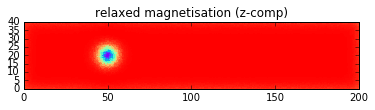

In [4]:
sim = Sim(mesh, Ms=5.8e5, unit_length=1e-9, pbc=None)

sim.add(UniaxialAnisotropy(K1=6e5, axis=[0, 0, 1]))
sim.add(Exchange(A=1.5e-11))
sim.add(DMI(D=3e-3))
sim.add(Zeeman((0, 0, 1e5)))
sim.alpha = 0.5
    
sim.set_m(m_init_one)
    
sim.relax()
plot_2d_comp(sim, comp='z', title='relaxed magnetisation (z-comp)')

## Moving a skyrmion with Zhang-Li term

We apply a spin-polarised current in the $x$ direction.

In [5]:
Jx = (-2e12, 0, 0)

Now, we can add a Zhang-Li term to the LLG equation.

[2016-07-05 12:17:47] WARNING: Removing file 'vtks/m.pvd' and all associated .vtu files (because overwrite=True).
[2016-07-05 12:17:47] INFO: Simulation will run until t = 5e-10 s.
[2016-07-05 12:17:47] DEBUG: Saved field at t=1.54235491757e-10 to file 'vtks/m.pvd' (snapshot #0; saving took 0.042 seconds).
[2016-07-05 12:17:47] DEBUG: Overwriting 4 existing file(s) 'npys/m.pvd*.npy'.
[2016-07-05 12:17:47] DEBUG: Saving field data to file 'npys/m.pvd_000000.npy'.
[2016-07-05 12:17:47] INFO: plot_2d_comp: at t = 1.54235e-10
[2016-07-05 12:19:00] DEBUG: Saved field at t=2.54235491757e-10 to file 'vtks/m.pvd' (snapshot #1; saving took 0.0321 seconds).
[2016-07-05 12:19:00] DEBUG: Saving field data to file 'npys/m.pvd_000001.npy'.
[2016-07-05 12:19:00] INFO: plot_2d_comp: at t = 2.54235e-10
[2016-07-05 12:20:15] DEBUG: Saved field at t=3.54235491757e-10 to file 'vtks/m.pvd' (snapshot #2; saving took 0.0327 seconds).
[2016-07-05 12:20:15] DEBUG: Saving field data to file 'npys/m.pvd_000002.n

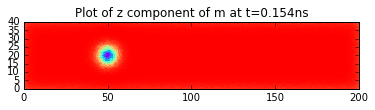

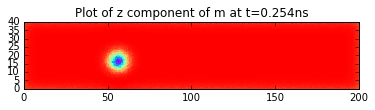

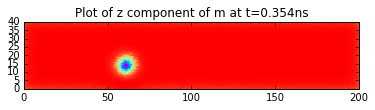

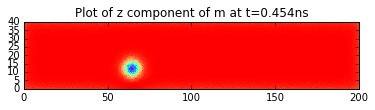

In [6]:
#We use the zhang-li spin-transfer torque with parameters that polarisation=0.5 and beta=0.01
sim.set_zhangli(Jx, P=0.5, beta=0.01, using_u0=False)
    
# every 0.1ns save vtk data
sim.schedule('save_vtk', every=1e-10, filename='vtks/m.pvd', overwrite=True)
# every 0.1ns save raw data
sim.schedule('save_m', every=1e-10, filename='npys/m.pvd', overwrite=True)
# every 0.1ns create plot for notebook
sim.schedule(plot_2d_comp, every=1e-10)
    
# now do the calculation (events scheduled above will be done automatically)
sim.run_until(0.5e-9)

## Slonczewski spin-transfer torque

If we want to move a skyrmion with perpendicular current (Slonczewski STT term), the following line should be used instead of `set_zhangli` method.

In [7]:
#sim.set_stt(current_density=1e10, polarisation=0.5, thickness=0.4e-9, direction=(0,1,0))